In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#Transforms
transformer=transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    torchvision.transforms.Grayscale(num_output_channels=1)
])

#dataloader
train_path =  r"C:\Dataset\Train_set"
test_path = r"C:\Dataset\Test_set"
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=48, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=24, shuffle=True
)
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

cuda
['L4', 'day1', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day2', 'day20', 'day21', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'others']


In [2]:
import torch
import torch.nn as nn
from math import ceil

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(1, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [3]:
model=EfficientNet("b0", num_classes=23).to(device)
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)

77846 23666


In [4]:
import torch
import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [5]:
y_pred = []
y_true = []
train_losses = []
test_accuracies = []
best_accuracy= 0.0
test_accuracy=0.0
train_accuracy=0.0
train_loss=0.0

In [6]:
def train_test(start_epochs, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred):
    #Model training and saving best model

    for epoch in range(start_epochs, num_epochs+1):

        #Evaluation and training on training dataset
        model.train()

        for i, (images,labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            optimizer.zero_grad()

            outputs=model(images)
            loss=loss_function(outputs,labels)
            loss.backward()
            optimizer.step()

            train_loss+= loss.cpu().data*images.size(0)
            _,prediction=torch.max(outputs.data,1)

            train_accuracy+=int(torch.sum(prediction==labels.data))

        train_accuracy=train_accuracy/train_count
        train_loss=train_loss/train_count

        # Evaluation on testing dataset
        model.eval()

        for i, (images,labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            outputs=model(images)
            _,prediction=torch.max(outputs.data,1)
            test_accuracy+=int(torch.sum(prediction==labels.data))

            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

        test_accuracy=test_accuracy/test_count

        print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
        
        train_losses.append(train_loss.item())
        test_accuracies.append(test_accuracy)
        checkpoint = {
                'start_epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_accuracy': best_accuracy,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'train_loss': train_loss,
                'train_losses':train_losses,
                'test_accuracies': test_accuracies,
                'y_true': y_true,
                'y_pred': y_pred
        }
        save_ckp(checkpoint, False, checkpoint_path='current_checkpoint_efficientNet_b0.pt', best_model_path='best_checkpoint_efficientNet_b0.model')
        #Save the best model
        if test_accuracy>best_accuracy:
            torch.save(model.state_dict(),'best_checkpoint_efficientNet_b0.model')
            best_accuracy=test_accuracy
            checkpoint['best_accuracy']=best_accuracy
            save_ckp(checkpoint, True, checkpoint_path='current_checkpoint_efficientNet_b0.pt', best_model_path='best_checkpoint_efficientNet_b0.model')

In [7]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    best_accuracy = checkpoint['best_accuracy']
    train_accuracy = checkpoint['train_accuracy']
    test_accuracy = checkpoint['test_accuracy']
    train_loss = checkpoint['train_loss']    
    train_losses = checkpoint['train_losses']    
    test_accuracies = checkpoint['test_accuracies']   
    start_epoch = checkpoint['start_epoch']
    y_true = checkpoint['y_true']
    y_pred = checkpoint['y_pred']
    return model, optimizer,start_epoch,best_accuracy, train_accuracy,test_accuracy,train_loss.item(),train_losses,test_accuracies,y_true,y_pred

In [8]:
def conf_matrix(y_true,y_pred):
     # constant for classes
    classes = ('L4', 'day1', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day2', 'day20', 'day21', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'others')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

In [9]:
def learn_curve_train_losses(train_losses):
    plt.plot(train_losses,'-o')
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend(['Train'])
    plt.title('Train Losses Per Epoch')

    plt.show()
    
def learn_curve_test_accuracies(test_accuracies):
    plt.plot(test_accuracies,'-r')
    plt.xlabel('epoch')
    plt.ylabel('test_accuracy')
    plt.legend(['Test Accuracy'])
    plt.title('Test Accuracy Per Epoch')
    plt.show()


In [10]:
num_epochs = 25

import os.path

if os.path.isfile("current_checkpoint_effecientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)


Epoch: 1 Train Loss: tensor(2.4516) Train Accuracy: 0.19511599825296097 Test Accuracy: 0.128158539677174
Epoch: 2 Train Loss: tensor(1.9759) Train Accuracy: 0.3170643978624239 Test Accuracy: 0.3689735552497117
Epoch: 3 Train Loss: tensor(1.6002) Train Accuracy: 0.45370753878680814 Test Accuracy: 0.45615520043755814
Epoch: 4 Train Loss: tensor(1.2781) Train Accuracy: 0.5682431172769158 Test Accuracy: 0.5579082293247882
Epoch: 5 Train Loss: tensor(1.0792) Train Accuracy: 0.6364690317179723 Test Accuracy: 0.585293581857066
Epoch: 6 Train Loss: tensor(0.9515) Train Accuracy: 0.6779877767519424 Test Accuracy: 0.5904075590966728
Epoch: 7 Train Loss: tensor(0.8472) Train Accuracy: 0.7162818640363893 Test Accuracy: 0.6225636105619495
Epoch: 8 Train Loss: tensor(0.7674) Train Accuracy: 0.7434642278583875 Test Accuracy: 0.651129154213241
Epoch: 9 Train Loss: tensor(0.6967) Train Accuracy: 0.7691691732937834 Test Accuracy: 0.6550600494022739
Epoch: 10 Train Loss: tensor(0.6332) Train Accuracy: 0.

In [ ]:
num_epochs = 35

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 26 Train Loss: tensor(0.2428) Train Accuracy: 0.9185560638253348 Test Accuracy: 0.7782369970357588
Epoch: 27 Train Loss: tensor(0.2418) Train Accuracy: 0.9200462266020583 Test Accuracy: 0.7786181964420281
Epoch: 28 Train Loss: tensor(0.2328) Train Accuracy: 0.9227952630350513 Test Accuracy: 0.7483215844754686


In [10]:
num_epochs = 45

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 29 Train Loss: tensor(0.2265) Train Accuracy: 0.925030480631799 Test Accuracy: 0.7876594406145727
Epoch: 30 Train Loss: tensor(0.2184) Train Accuracy: 0.9274069962551786 Test Accuracy: 0.7833511222614982
Epoch: 31 Train Loss: tensor(0.2075) Train Accuracy: 0.9310424094622236 Test Accuracy: 0.7702942343920504
Epoch: 32 Train Loss: tensor(0.2076) Train Accuracy: 0.9329307998151409 Test Accuracy: 0.7775192383264765
Epoch: 33 Train Loss: tensor(0.1964) Train Accuracy: 0.9348962429771577 Test Accuracy: 0.7839422597497814
Epoch: 34 Train Loss: tensor(0.1920) Train Accuracy: 0.9361037804928061 Test Accuracy: 0.7969992369753972
Epoch: 35 Train Loss: tensor(0.1878) Train Accuracy: 0.9386087416666302 Test Accuracy: 0.7980139017678094
Epoch: 36 Train Loss: tensor(0.1808) Train Accuracy: 0.9407540350016913 Test Accuracy: 0.7961969920519635
Epoch: 37 Train Loss: tensor(0.1848) Train Accuracy: 0.9392382492875034 Test Accuracy: 0.7746047577534036
Epoch: 38 Train Loss: tensor(0.1761) Train Accu

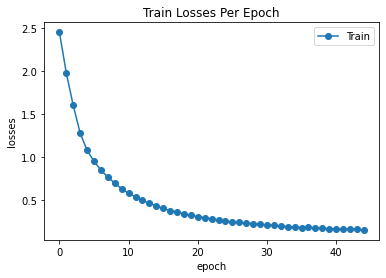

In [11]:
learn_curve_train_losses(train_losses)

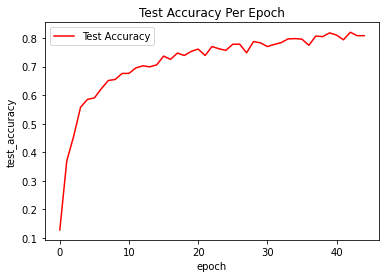

In [12]:
learn_curve_test_accuracies(test_accuracies)

In [13]:
num_epochs = 50

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 46 Train Loss: tensor(0.1538) Train Accuracy: 0.949283834413115 Test Accuracy: 0.8014370119379938
Epoch: 47 Train Loss: tensor(0.1492) Train Accuracy: 0.9519429294226346 Test Accuracy: 0.8250993592923155
Epoch: 48 Train Loss: tensor(0.1478) Train Accuracy: 0.9514676661990265 Test Accuracy: 0.7970009760567605
Epoch: 49 Train Loss: tensor(0.1437) Train Accuracy: 0.953612921250497 Test Accuracy: 0.8091268909395782
Epoch: 50 Train Loss: tensor(0.1448) Train Accuracy: 0.9520714437854385 Test Accuracy: 0.8212967601999045


In [ ]:
num_epochs = 60

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 51 Train Loss: tensor(0.1426) Train Accuracy: 0.9531504774997275 Test Accuracy: 0.8217620762596215
Epoch: 52 Train Loss: tensor(0.1402) Train Accuracy: 0.9547947633851128 Test Accuracy: 0.8141985025807597
Epoch: 53 Train Loss: tensor(0.1386) Train Accuracy: 0.9551930066382779 Test Accuracy: 0.8048176370532655
Epoch: 54 Train Loss: tensor(0.1360) Train Accuracy: 0.9556811550112612 Test Accuracy: 0.8050707689359019


In [10]:
num_epochs = 60

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 58 Train Loss: tensor(0.1326) Train Accuracy: 0.956991469264357 Test Accuracy: 0.8136918442058286
Epoch: 59 Train Loss: tensor(0.1304) Train Accuracy: 0.9568629986315194 Test Accuracy: 0.8263675184587259
Epoch: 60 Train Loss: tensor(0.1280) Train Accuracy: 0.9584045020039389 Test Accuracy: 0.8310160723197184


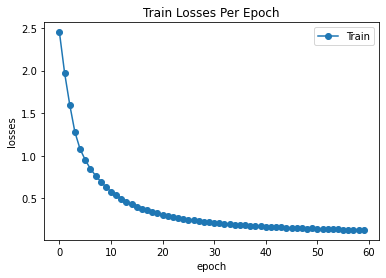

In [11]:
learn_curve_train_losses(train_losses)

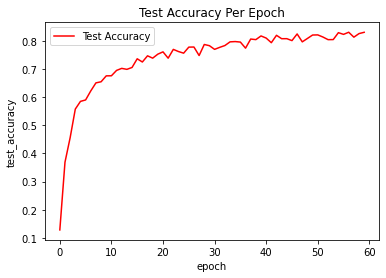

In [12]:
learn_curve_test_accuracies(test_accuracies)

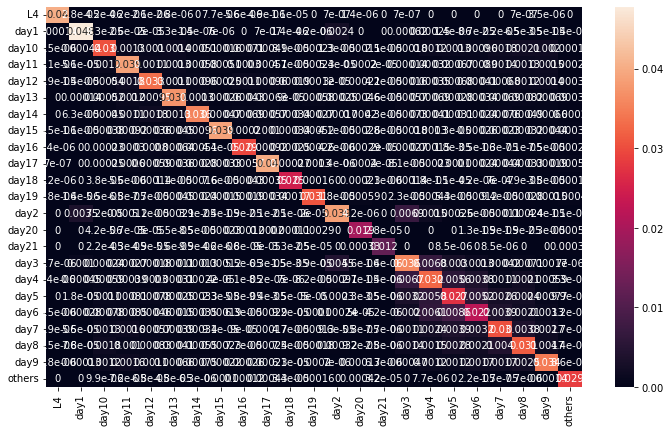

In [13]:
conf_matrix(y_true,y_pred)